# SHRED for ROMs: assessment of the physical consistency

This notebook serves as assessment of the physical consistency of the SHRED model for ROMs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
from pyforce.tools.functions_list import FunctionsList

import vtk
import pyvista as pv
import dolfinx

# Comment this line if you don't want to use the SSH connection
# pv.start_xvfb()

var_names, is_vector, times = pickle.load(open('/Users/sriva/Github/PublicRepo/NuSHRED/Code/P1/msfr_uloff.set', 'rb'))

path_svd = '/Users/sriva/Github/PublicRepo/NuSHRED/Code/P1/OfflineSVD/'
u_total = pickle.load(open(path_svd+'u_total.svd', 'rb'))
v_total = pickle.load(open(path_svd+'v_total.svd', 'rb'))
s_total = pickle.load(open(path_svd+'s_total.svd', 'rb'))

var_names = pickle.load(open(path_svd+"var.names", 'rb'))
rescaling_snaps = pickle.load(open(path_svd+"rescaling.svd", 'rb'))
Nmodes = pickle.load(open(path_svd+"Nmodes.svd", 'rb'))

incore_measure = False

if incore_measure:
    path_test = '/Users/sriva/Github/PublicRepo/NuSHRED/Code/P1/Test_results/InCore/'
    measurements = pickle.load(open(path_svd+'measurements_incore.data', 'rb'))
else:
    path_test = '/Users/sriva/Github/PublicRepo/NuSHRED/Code/P1/Test_results/'
    measurements = pickle.load(open(path_svd+'measurements_3.data', 'rb'))
    # measurements = pickle.load(open(path_svd+'measurements_10.data', 'rb'))
    
# Load the results
test_recons, test_ground_truth, _ = pickle.load(open(path_test+'test.results', 'rb'))

binned_stats = pickle.load(open(path_test+'binned.statitics', 'rb'))

if incore_measure:
    path_shred = '/Users/sriva/Github/PublicRepo/NuSHRED/Code/P1/SHRED/InCore/'
else:
    path_shred = '/Users/sriva/Github/PublicRepo/NuSHRED/Code/P1/SHRED/'
test_datasets = pickle.load(open(path_shred+'datasets.test', 'rb'))

new_t = np.linspace(min(times), max(times), len(measurements['noisy_output'][0,:,0]))

/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/ufl/__init__.py:244: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Let us define the tex variables

In [2]:
energy_groups = 6
tex_var_names = [r'\phi_'+str(g+1) for g in range(energy_groups)]

prec_groups = 8
tex_var_names.extend([r'c_'+str(g+1) for g in range(prec_groups)])

dec_groups = 3
tex_var_names.extend([r'd_'+str(g+1) for g in range(dec_groups)])

tex_var_names.extend(['T', 'p', r'\mathbf{u}'])

assert len(tex_var_names) == len(var_names)

Let us import the mesh and let us define the functional spaces

In [3]:
from mesh import *
from dolfinx.fem import Function, FunctionSpace, locate_dofs_topological
import ufl
from IPython.display import clear_output

domain, ct, ft = evol_mesh()

fun_spaces = [FunctionSpace(domain, ('Lagrange', 1))]*(len(var_names)-1)
fun_spaces.append(FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1)))

measured_field = 0

clear_output()

reflector_mark = 20
refl_tags = locate_dofs_topological(fun_spaces[measured_field], ct.dim, ct.find(reflector_mark))
Nh = fun_spaces[measured_field].tabulate_dof_coordinates().shape[0]

Let us define the function to map from *dolfinx.fem.dolfinx* to grid for *pyvista*

In [4]:
def vector_grids(fun: dolfinx.fem.Function, mag_plot: bool, varname='u'):
    
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    grid = pv.UnstructuredGrid(topology, cells, geometry)

    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(fun)] = np.real(fun.x.array.reshape(geometry.shape[0], len(fun)))
    grid[varname] = values

    if mag_plot:
        warped = grid.warp_by_vector(varname, factor=0.0) 
    else:
        warped = grid.glyph(varname, factor=0.25, tolerance=0.02)
        
    return warped, values

def grids(fun: dolfinx.fem.Function, log_plot = False):
    topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    if log_plot:
        u_grid.point_data['fun'] = np.log10(fun.x.array[:].real)
    else:
        u_grid.point_data['fun'] = fun.x.array[:].real

    u_grid.set_active_scalars('fun')
    return u_grid

At first, let us reconstruct the state for any test value of time

In [5]:
import os
from pyforce.tools.backends import LoopProgress

field_i = 19
path_fig = path_test+'/Users/sriva/Github/PublicRepo/NuSHRED/Code/P1/Fig_std/'+var_names[field_i]+'/'
if not os.path.exists(path_fig):
    os.makedirs(path_fig)

v_truth = list()
v_shred = list()

bar = LoopProgress('Reconstructing - '+var_names[field_i], final = len(test_ground_truth))
for kk in range(len(test_ground_truth)):

    u_ = u_total[var_names[field_i]]
    s_ = np.diag(s_total[var_names[field_i]])

    # FOM
    v_truth.append(test_ground_truth[kk][:,3 + sum(Nmodes[:field_i]) : 3 + sum(Nmodes[:field_i+1])])
    
    # SHRED
    v_shred.append(test_recons[kk][:,3 + sum(Nmodes[:field_i]) : 3 + sum(Nmodes[:field_i+1])])
    
    bar.update(1)

Reconstructing - U: 10.000 / 10.00 - 0.000 s/it


Let us compute the mean and the standard deviation of FOM and SHRED latent dynamics

In [6]:
import pandas as pd

plot_fom_binned_stats   = list()
plot_shred_binned_stats = list()

# Determine time bins
bin_width = 0.25

bar = LoopProgress('Evaluate Mean&Std', final = v_shred[0].shape[1])

for mesh_idx in range(v_shred[0].shape[1]):
    
    # FOM
    data = pd.DataFrame({
        'time': np.hstack([new_t[_test['idx']] for _test in test_datasets]),
        'fom': np.hstack([_test[:, mesh_idx] for _test in v_truth]),
    })
    bins = np.arange(0, max(data['time']) + bin_width, bin_width)
    data['bin'] = pd.cut(data['time'], bins, right=False)
    binned_stats_tmp = data.groupby('bin', observed=True)['fom'].agg(['mean', 'std']).reset_index()
    binned_stats_tmp['time'] = bins[:-1] + bin_width / 2

    plot_fom_binned_stats.append(binned_stats_tmp.dropna())
    
    # SHRED
    data = pd.DataFrame({
        'time': np.hstack([new_t[_test['idx']] for _test in test_datasets]),
        'shred': np.hstack([_test[:, mesh_idx] for _test in v_shred]),
    })
    bins = np.arange(0, max(data['time']) + bin_width, bin_width)
    data['bin'] = pd.cut(data['time'], bins, right=False)
    binned_stats_tmp = data.groupby('bin', observed=True)['shred'].agg(['mean', 'std']).reset_index()
    binned_stats_tmp['time'] = bins[:-1] + bin_width / 2

    plot_shred_binned_stats.append(binned_stats_tmp.dropna())
    
    bar.update(1)
    
fom_v_mean = np.array([df['mean'].to_numpy() for df in plot_fom_binned_stats])
fom_v_std  = np.array([df['std'].to_numpy()  for df in plot_fom_binned_stats])

shred_v_mean = np.array([df['mean'].to_numpy() for df in plot_shred_binned_stats])
shred_v_std  = np.array([df['std'].to_numpy()  for df in plot_shred_binned_stats])

fom = (u_ @ s_ @ fom_v_mean) * rescaling_snaps[field_i]
prediction = (u_ @ s_ @ shred_v_mean) * rescaling_snaps[field_i] 
std_dev_prediction = (u_ @ s_ @ shred_v_std) * rescaling_snaps[field_i] 

fom_list = FunctionsList(fun_spaces[field_i])
for mu in range(fom.shape[1]):
    fom_list.append(fom[:,mu])
    
pred_list = FunctionsList(fun_spaces[field_i])
for mu in range(prediction.shape[1]):
    pred_list.append(prediction[:,mu])
    
std_pred_list = FunctionsList(fun_spaces[field_i])
for mu in range(std_dev_prediction.shape[1]):
    std_pred_list.append(std_dev_prediction[:,mu])
    
time_bins = plot_shred_binned_stats[0]['time'].to_numpy()

Evaluate Mean&Std: 10.000 / 10.00 - 0.007 s/it


## Check the continuity equation (Mass conservation)
The MSFR MP model considers the fluid to be incompressible: in the following, the divergence of the velocity is computed for both FOM and SHRED predictions to check the mass conservation.
$$
\nabla\cdot \mathbf{u} = 0
$$

In [8]:
cont_eqn_fom   = np.asarray([np.abs(vector_grids(fom_list.map(tt),  mag_plot=True)[0].compute_derivative(scalars='u', divergence=True)['divergence']) for tt in range(len(fom_list))])
cont_eqn_shred = np.asarray([np.abs(vector_grids(pred_list.map(tt), mag_plot=True)[0].compute_derivative(scalars='u', divergence=True)['divergence']) for tt in range(len(pred_list))])

Let us make a plot over time

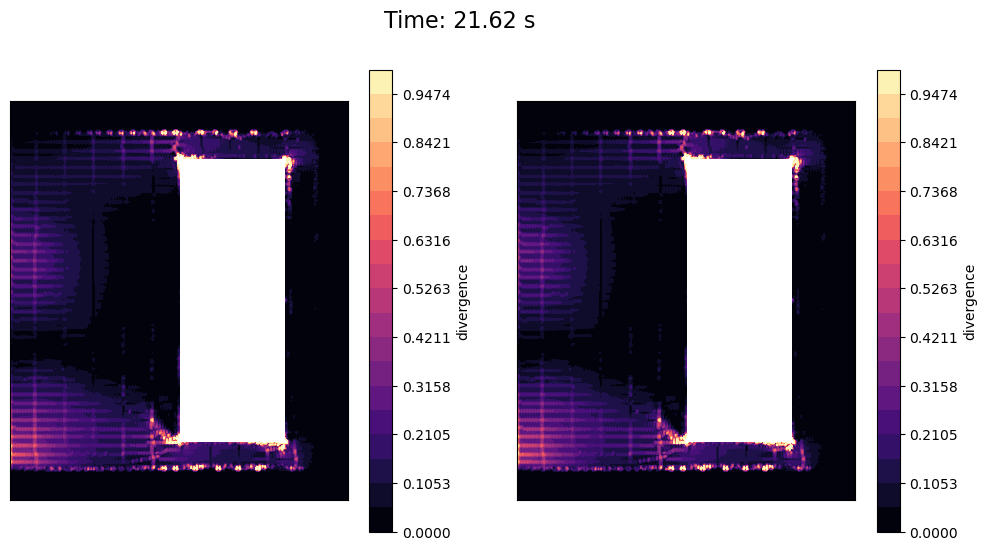

In [18]:
from matplotlib import patches

def get_msfr_geometry(ax, show_ticks = False):
    # Defining the rectangles for the blue zones
    rect_blanket = patches.Rectangle((1.13, -1.88/2), 0.7, 1.88, linewidth=1, facecolor='white')

    ax.add_patch(rect_blanket)

    # Setting the limits and aspect
    ax.set_xlim(0, 2.25)
    ax.set_ylim(-2.66/2, 2.66/2)
    ax.set_aspect('equal')

    if not show_ticks:
        ax.set_xticks([])
        ax.set_yticks([])

from IPython.display import clear_output as clc

mesh_plot = domain.geometry.x[:, :2]
levels = np.linspace(0, 1, 20)

for tt in range(5, len(fom_list), 5):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    cont = axs[0].tricontourf(mesh_plot[:, 0], mesh_plot[:, 1], (cont_eqn_fom[tt]), levels=levels, cmap=cm.magma)
    fig.colorbar(cont, ax=axs[0], label='divergence')
    get_msfr_geometry(axs[0])

    cont = axs[1].tricontourf(mesh_plot[:, 0], mesh_plot[:, 1], (cont_eqn_shred[tt]), levels=levels, cmap=cm.magma)
    fig.colorbar(cont, ax=axs[1], label='divergence')
    get_msfr_geometry(axs[1])

    fig.suptitle(f'Time: {time_bins[tt]:.2f} s', fontsize=16)

    plt.show()
    clc(wait=True)
    plt.close()